**EDA Objective:** Identify and retain low-cost NHANES variables that may help predict costly or invasive lab biomarkers (vitamin D, HDL cholesterol).

- Data: NHANES 2013–2014 (public .xpt files)
- Targets: vitamin_d, hdl_cholesterol
- Inputs: demographics, smoking/alcohol, vitals, occupation, physical activity

In [2]:
# install and load packages/libraries

!pip install pyreadstat
import pyreadstat
from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import os
from functools import reduce
from pathlib import Path
import json
from matplotlib.font_manager import FontProperties
from pandas.api.types import CategoricalDtype, is_categorical_dtype

In [3]:
# Global plot style 

sns.set_style("white")  # Removes background grid lines
plt.rcParams.update({
    'figure.dpi': 200,
    'savefig.dpi': 300,
    'font.family': ['Avenir', 'sans-serif'],   # Add nicer font
    'font.size': 10,                       # Increase base font size
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'axes.grid': False
})

avenir_font = FontProperties(family='Avenir')


In [4]:
# === Step 1: Define raw NHANES files to load ===
raw_files = {
    "ALQ_I": "Alcohol Use",
    "BMX_I": "Body Measures",
    "BPX_I": "Blood Pressure",
    "DEMO_I": "Demographics",
    "INQ_I": "Income",
    "OCQ_I": "Occupation",
    "PAQ_I": "Physical Activity",
    "SMQ_I": "Smoking",
    "ALB_CR_I": "Urine Albumin/Creatinine",
    "GHB_I": "Glycohemoglobin",
    "HDL_I": "HDL",
    "TRIGLY_I": "Triglycerides/LDL",
    "VID_I": "Vitamin D"
}

# === Step 2: Load and merge all files on SEQN ===
dfs = []
for code in raw_files:
    path = f"../data/raw/{code}.xpt.txt"
    df, _ = pyreadstat.read_xport(path)
    dfs.append(df)

df_merged = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='outer'), dfs)

# === Step 3: Select columns and drop rows missing any target ===
target_cols_raw = ['LBXVIDMS', 'LBDHDD']
feature_cols_raw = [
    'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDEDUC2', 'DMDCITZN', 'DMDMARTL',
    'BPXSY1', 'BPXDI1', 'BMXBMI', 'BMXWAIST',
    'SMQ020', 'SMQ040', 'SMQ050Q', 'SMQ080',
    'ALQ130', 'ALQ120Q',
    'PAQ605', 'PAQ620',
    'OCQ260', 'OCQ380',
    'IND235', 'INDFMMPI', 'INQ020', 'INQ300', 'IND310'
]
all_cols = ['SEQN'] + feature_cols_raw + target_cols_raw
df_model = df_merged[all_cols].dropna(subset=target_cols_raw).copy()

# === Step 4: Rename columns ===
rename_map = {
    # Targets
    'LBXVIDMS': 'vitamin_d', 'LBDHDD': 'hdl_cholesterol',
    # Demographics
    'RIAGENDR': 'sex', 'RIDAGEYR': 'age', 'RIDRETH1': 'race_ethnicity', 'INDFMPIR': 'poverty_income_ratio',
    'DMDEDUC2': 'education', 'DMDCITZN': 'citizenship', 'DMDMARTL': 'marital_status',
    # Vitals
    'BPXSY1': 'systolic_bp', 'BPXDI1': 'diastolic_bp', 'BMXBMI': 'bmi', 'BMXWAIST': 'waist_circumference',
    # Smoking
    'SMQ020': 'ever_smoked_100', 'SMQ040': 'current_smoker', 'SMQ050Q': 'cigs_per_day', 'SMQ080': 'age_started_smoking',
    # Alcohol
    'ALQ120Q': 'alc_freq_past12mo', 'ALQ130': 'drinks_per_day',
    # Physical Activity
    'PAQ605': 'intense_activity_work', 'PAQ620': 'some_activity_work',
    # Occupation
    'OCQ260': 'worked_last_week', 'OCQ380': 'hours_worked_week',
    # Income
    'IND235': 'monthly_family_income', 'INDFMMPI': 'monthly_poverty_ratio',
    'INQ020': 'has_wage_income', 'INQ300': 'has_20k_savings', 'IND310': 'total_savings'
}
df_model.rename(columns=rename_map, inplace=True)

# === Step 5: Classify features ===
target_cols = ['vitamin_d', 'hdl_cholesterol']

explicit_cats = [
    'sex', 'race_ethnicity', 'education', 'citizenship', 'marital_status',
    'ever_smoked_100', 'current_smoker', 'has_wage_income', 'has_20k_savings',
    'intense_activity_work', 'some_activity_work', 'worked_last_week',
    'monthly_family_income', 'total_savings'
]

cat_features = [col for col in explicit_cats if col in df_model.columns]
num_features = [
    col for col in df_model.columns
    if col not in cat_features + target_cols + ['SEQN'] and np.issubdtype(df_model[col].dtype, np.number)
]

# Optional: convert categoricals to category dtype
df_model[cat_features] = df_model[cat_features].astype('category')

# === Step 6: Sanity check ===
classified = set(cat_features + num_features + target_cols + ['SEQN'])
all_columns = set(df_model.columns)
missing = all_columns - classified
extra = classified - all_columns

assert not missing, f"Unclassified columns: {missing}"
assert not extra, f"Invalid columns: {extra}"
assert len(classified) == df_model.shape[1], "Mismatch in total classified columns."

# === Final prints ===
print("✅ Data successfully loaded, merged, renamed, and classified.\n")
print(f"🔤 Categorical features ({len(cat_features)}):")
print(cat_features)
print("\n🧮 Numerical features ({len(num_features)}):")
print(num_features)
print("\n🎯 Target variables:")
print(target_cols)


✅ Data successfully loaded, merged, renamed, and classified.

🔤 Categorical features (14):
['sex', 'race_ethnicity', 'education', 'citizenship', 'marital_status', 'ever_smoked_100', 'current_smoker', 'has_wage_income', 'has_20k_savings', 'intense_activity_work', 'some_activity_work', 'worked_last_week', 'monthly_family_income', 'total_savings']

🧮 Numerical features ({len(num_features)}):
['age', 'poverty_income_ratio', 'systolic_bp', 'diastolic_bp', 'bmi', 'waist_circumference', 'cigs_per_day', 'age_started_smoking', 'drinks_per_day', 'alc_freq_past12mo', 'hours_worked_week', 'monthly_poverty_ratio']

🎯 Target variables:
['vitamin_d', 'hdl_cholesterol']


In [5]:
# Remove invalid entries

def remove_manual_invalid_entries(df):
    """
    Removes rows with special coded values for 'refused', 'don't know', or implausible responses
    across selected features. This includes values like 777, 999, 7, or 9.
    """
    df = df.copy()

    # Define problematic values by feature
    invalid_values = {
        'drinks_per_day': [777, 999],
        'alc_freq_past12mo': [777, 999],
        'intense_activity_work': [7, 9],
        'some_activity_work': [7, 9],
        'monthly_family_income': [77, 99],
        'has_20k_savings': [7, 9],
        'total_savings': [77, 99]
    }

    # Apply filters
    for col, bad_vals in invalid_values.items():
        if col in df.columns:
            before = len(df)
            df = df[~df[col].isin(bad_vals)]
            after = len(df)
            print(f"🧹 Removed {before - after} rows from '{col}' with invalid values: {bad_vals}")

    return df


df_model = remove_manual_invalid_entries(df_model)

🧹 Removed 3 rows from 'drinks_per_day' with invalid values: [777, 999]
🧹 Removed 1 rows from 'alc_freq_past12mo' with invalid values: [777, 999]
🧹 Removed 2 rows from 'intense_activity_work' with invalid values: [7, 9]
🧹 Removed 4 rows from 'some_activity_work' with invalid values: [7, 9]
🧹 Removed 707 rows from 'monthly_family_income' with invalid values: [77, 99]
🧹 Removed 85 rows from 'has_20k_savings' with invalid values: [7, 9]
🧹 Removed 50 rows from 'total_savings' with invalid values: [77, 99]


In [6]:
# === Remove extrema based on previously defined numerical features ===

# Store original row count for comparison
original_rows = len(df_model)

# Step 1: Get per-column min and max
mins = df_model[num_features].min()
maxs = df_model[num_features].max()

# Step 2: Create masks for rows that are NOT at any min or max
not_min = ~(df_model[num_features] == mins).any(axis=1)
not_max = ~(df_model[num_features] == maxs).any(axis=1)

# Step 3: Apply combined mask
df_model = df_model[not_min & not_max].copy()

# Step 4: Report
removed_rows = original_rows - len(df_model)
print(f"✅ Removed {removed_rows} rows with min/max-clipped values from numerical features.")

✅ Removed 2949 rows with min/max-clipped values from numerical features.


In [7]:
# === Display name map for plotting and reports ===
display_name_map = {
    # Targets
    'vitamin_d': 'Vitamin D (ng/mL)',
    'hdl_cholesterol': 'HDL Cholesterol (mg/dL)',

    # Demographics
    'sex': 'Sex (cat)',
    'age': 'Age (years)',
    'race_ethnicity': 'Race/Ethnicity (cat)',
    'poverty_income_ratio': 'Poverty-Income Ratio',
    'education': 'Education Level (cat)',
    'citizenship': 'US Citizenship (Y/N)',
    'marital_status': 'Marital Status (cat)',

    # Vitals
    'systolic_bp': 'Systolic BP (mm Hg)',
    'diastolic_bp': 'Diastolic BP (mm Hg)',
    'bmi': 'BMI (kg/m²)',
    'waist_circumference': 'Waist Circumference (cm)',

    # Smoking
    'ever_smoked_100': 'Ever Smoked 100 Cigarettes (Y/N)',
    'current_smoker': 'Current Smoker (Y/N)',
    'cigs_per_day': 'Cigarettes per Day (count)',
    'age_started_smoking': 'Age Started Smoking (years)',

    # Alcohol
    'alc_freq_past12mo': 'Drinks in Past 12 Mo (count)',
    'drinks_per_day': 'Drinks per Day (count)',

    # Physical Activity
    'intense_activity_work': 'Intense Work Activity (Y/N)',
    'some_activity_work': 'Some Work Activity (Y/N)',

    # Occupation
    'worked_last_week': 'Worked Last Week (Y/N)',
    'hours_worked_week': 'Hours Worked per Week',

    # Income & Savings
    'monthly_family_income': 'Monthly Family Income ($)',
    'monthly_poverty_ratio': 'Poverty Index Ratio',
    'has_wage_income': 'Has Wage Income (Y/N)',
    'has_20k_savings': 'Has >$20k Savings (Y/N)',
    'total_savings': 'Total Savings ($)'
}

# === Sanity check: ensure all relevant columns have display names ===
all_needed = [col for col in num_features + cat_features + target_cols if col != 'SEQN']
missing_labels = [col for col in all_needed if col not in display_name_map]

if missing_labels:
    print("⚠️ Missing display names for:", missing_labels)
else:
    print("✅ All features and targets have display names.")

✅ All features and targets have display names.


In [8]:
# # Define label mappings

# === Define label mappings for categorical features ===
encoding_maps = {
    'sex': {1: 'Male', 2: 'Female'},
    'race_ethnicity': {
        1: 'Mexican American',
        2: 'Other Hispanic',
        3: 'Non-Hispanic White',
        4: 'Non-Hispanic Black',
        6: 'Non-Hispanic Asian',
        7: 'Other/Multi-Racial'
    },
    'education': {
        1: 'Less than 9th grade',
        2: '9–11th grade',
        3: 'High school/GED',
        4: 'Some college/AA',
        5: 'College grad or higher'
    },
    'citizenship': {
        1: 'US Citizen',
        2: 'Not US Citizen',
        3: 'Dual/Other'
    },
    'marital_status': {
        1: 'Married',
        2: 'Widowed',
        3: 'Divorced',
        4: 'Separated',
        5: 'Never married',
        6: 'Living with partner'
    },
    'ever_smoked_100': {1: 'Yes', 2: 'No'},
    'current_smoker': {1: 'Every day', 2: 'Some days', 3: 'Not at all'},
    'intense_activity_work': {1: 'Yes', 2: 'No'},
    'some_activity_work': {1: 'Yes', 2: 'No'},
    'worked_last_week': {1: 'Yes', 2: 'No'},
    'has_20k_savings': {1: 'Yes', 2: 'No'},
    'has_wage_income': {1: 'Yes', 2: 'No'},
    'total_savings': {
        1: '0 - 3,000',
        2: '3,001 - 5,000',
        3: '5,001 - 10,000',
        4: '10,001 - 15,000',
        5: '15,001 - 20,000'
    },
    'monthly_family_income': {
        1: '0 - 399',
        2: '400 - 799',
        3: '800 - 1,249',
        4: '1,250 - 1,649',
        5: '1,650 - 2,099',
        6: '2,100 - 2,899',
        7: '2,900 - 3,749',
        8: '3,750 - 4,599',
        9: '4,600 - 5,399',
        10: '5,400 - 6,249',
        11: '6,250 - 8,399',
        12: '8,400+'
    }
}

# === Apply mappings ===
for col, mapping in encoding_maps.items():
    if col in df_model.columns:
        df_model[col] = df_model[col].map(mapping)

print("✅ Applied label encoding to categorical variables.")

✅ Applied label encoding to categorical variables.


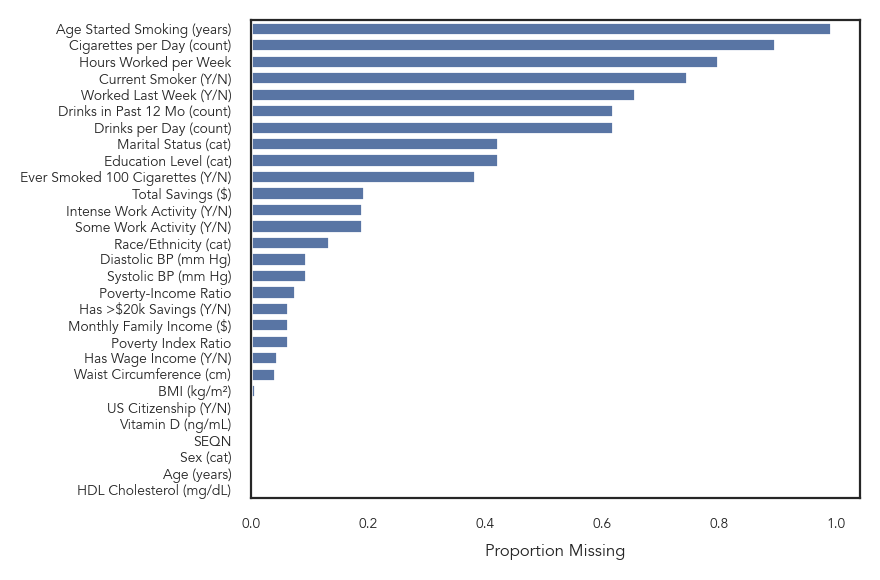

In [9]:
# Compute missing ratios from df_model
missing = df_model.isnull().mean().sort_values(ascending=False)

# Map raw column names to display labels using your dictionary
display_names = [display_name_map.get(col, col) for col in missing.index]

# Set figure height adaptively but cap max height
fig_height = min(0.18 * len(missing), 3)
fig, ax = plt.subplots(figsize=(4.5, fig_height))

sns.barplot(x=missing, y=display_names, color='#4C72B0', ax=ax)

ax.set_xlabel("Proportion Missing", fontsize=6)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=5)
ax.tick_params(axis='x', labelsize=5)
ax.grid(False)

plt.tight_layout()
plt.show()

In [10]:
# === Calculate missingness
missing_ratio = df_model.isnull().mean()

# === Identify columns with >50% missing
cols_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()

# === Drop from DataFrame
df_model = df_model.drop(columns=cols_to_drop)

# === Drop from display name map if synced
for col in cols_to_drop:
    display_name_map.pop(col, None)

# === Force 'monthly_family_income' into categorical
if 'monthly_family_income' in df_model.columns:
    if 'monthly_family_income' not in cat_features:
        cat_features.append('monthly_family_income')
    if 'monthly_family_income' in num_features:
        num_features.remove('monthly_family_income')

# === Clean up feature lists (ensure valid columns and drop SEQN)
cat_features = [
    col for col in cat_features
    if col in df_model.columns and col != 'SEQN'
]

num_features = [
    col for col in num_features
    if col in df_model.columns and col != 'SEQN'
]

target_vars = ['vitamin_d', 'hdl_cholesterol']

# === Force categorical dtype for all cat features
df_model[cat_features] = df_model[cat_features].astype('category')

# === Report dropped columns
print(f"🗑️ Dropped {len(cols_to_drop)} columns with >50% missing:")
for col in cols_to_drop:
    print(f"  - {col}: {missing_ratio[col]*100:.1f}% missing")

# === Report remaining features
print("\n🔤 Categorical features:")
for col in cat_features:
    print(f"  - {col}")

print("\n🧮 Numerical features:")
for col in num_features:
    print(f"  - {col}")


🗑️ Dropped 7 columns with >50% missing:
  - current_smoker: 74.6% missing
  - cigs_per_day: 89.6% missing
  - age_started_smoking: 99.1% missing
  - drinks_per_day: 61.9% missing
  - alc_freq_past12mo: 61.9% missing
  - worked_last_week: 65.7% missing
  - hours_worked_week: 79.8% missing

🔤 Categorical features:
  - sex
  - race_ethnicity
  - education
  - citizenship
  - marital_status
  - ever_smoked_100
  - has_wage_income
  - has_20k_savings
  - intense_activity_work
  - some_activity_work
  - monthly_family_income
  - total_savings

🧮 Numerical features:
  - age
  - poverty_income_ratio
  - systolic_bp
  - diastolic_bp
  - bmi
  - waist_circumference
  - monthly_poverty_ratio


In [11]:
# fix ordering of some variables

manual_orders = {
    'monthly_family_income': [
        '0 - 399', '400 - 799', '800 - 1,249', '1,250 - 1,649', '1,650 - 2,099',
        '2,100 - 2,899', '2,900 - 3,749', '3,750 - 4,599', '4,600 - 5,399',
        '5,400 - 6,249', '6,250 - 8,399', '8,400+'
    ],
    'total_savings': [
        '0 - 3,000', '3,001 - 5,000', '5,001 - 10,000',
        '10,001 - 15,000', '15,001 - 20,000'
    ]
}

for col, order in manual_orders.items():
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(str)
        dtype = CategoricalDtype(categories=order, ordered=True)
        df_model[col] = df_model[col].astype(dtype)

In [12]:
# print(df_model['monthly_family_income'].value_counts(dropna=False))
# print(df_model['monthly_family_income'].cat.categories)


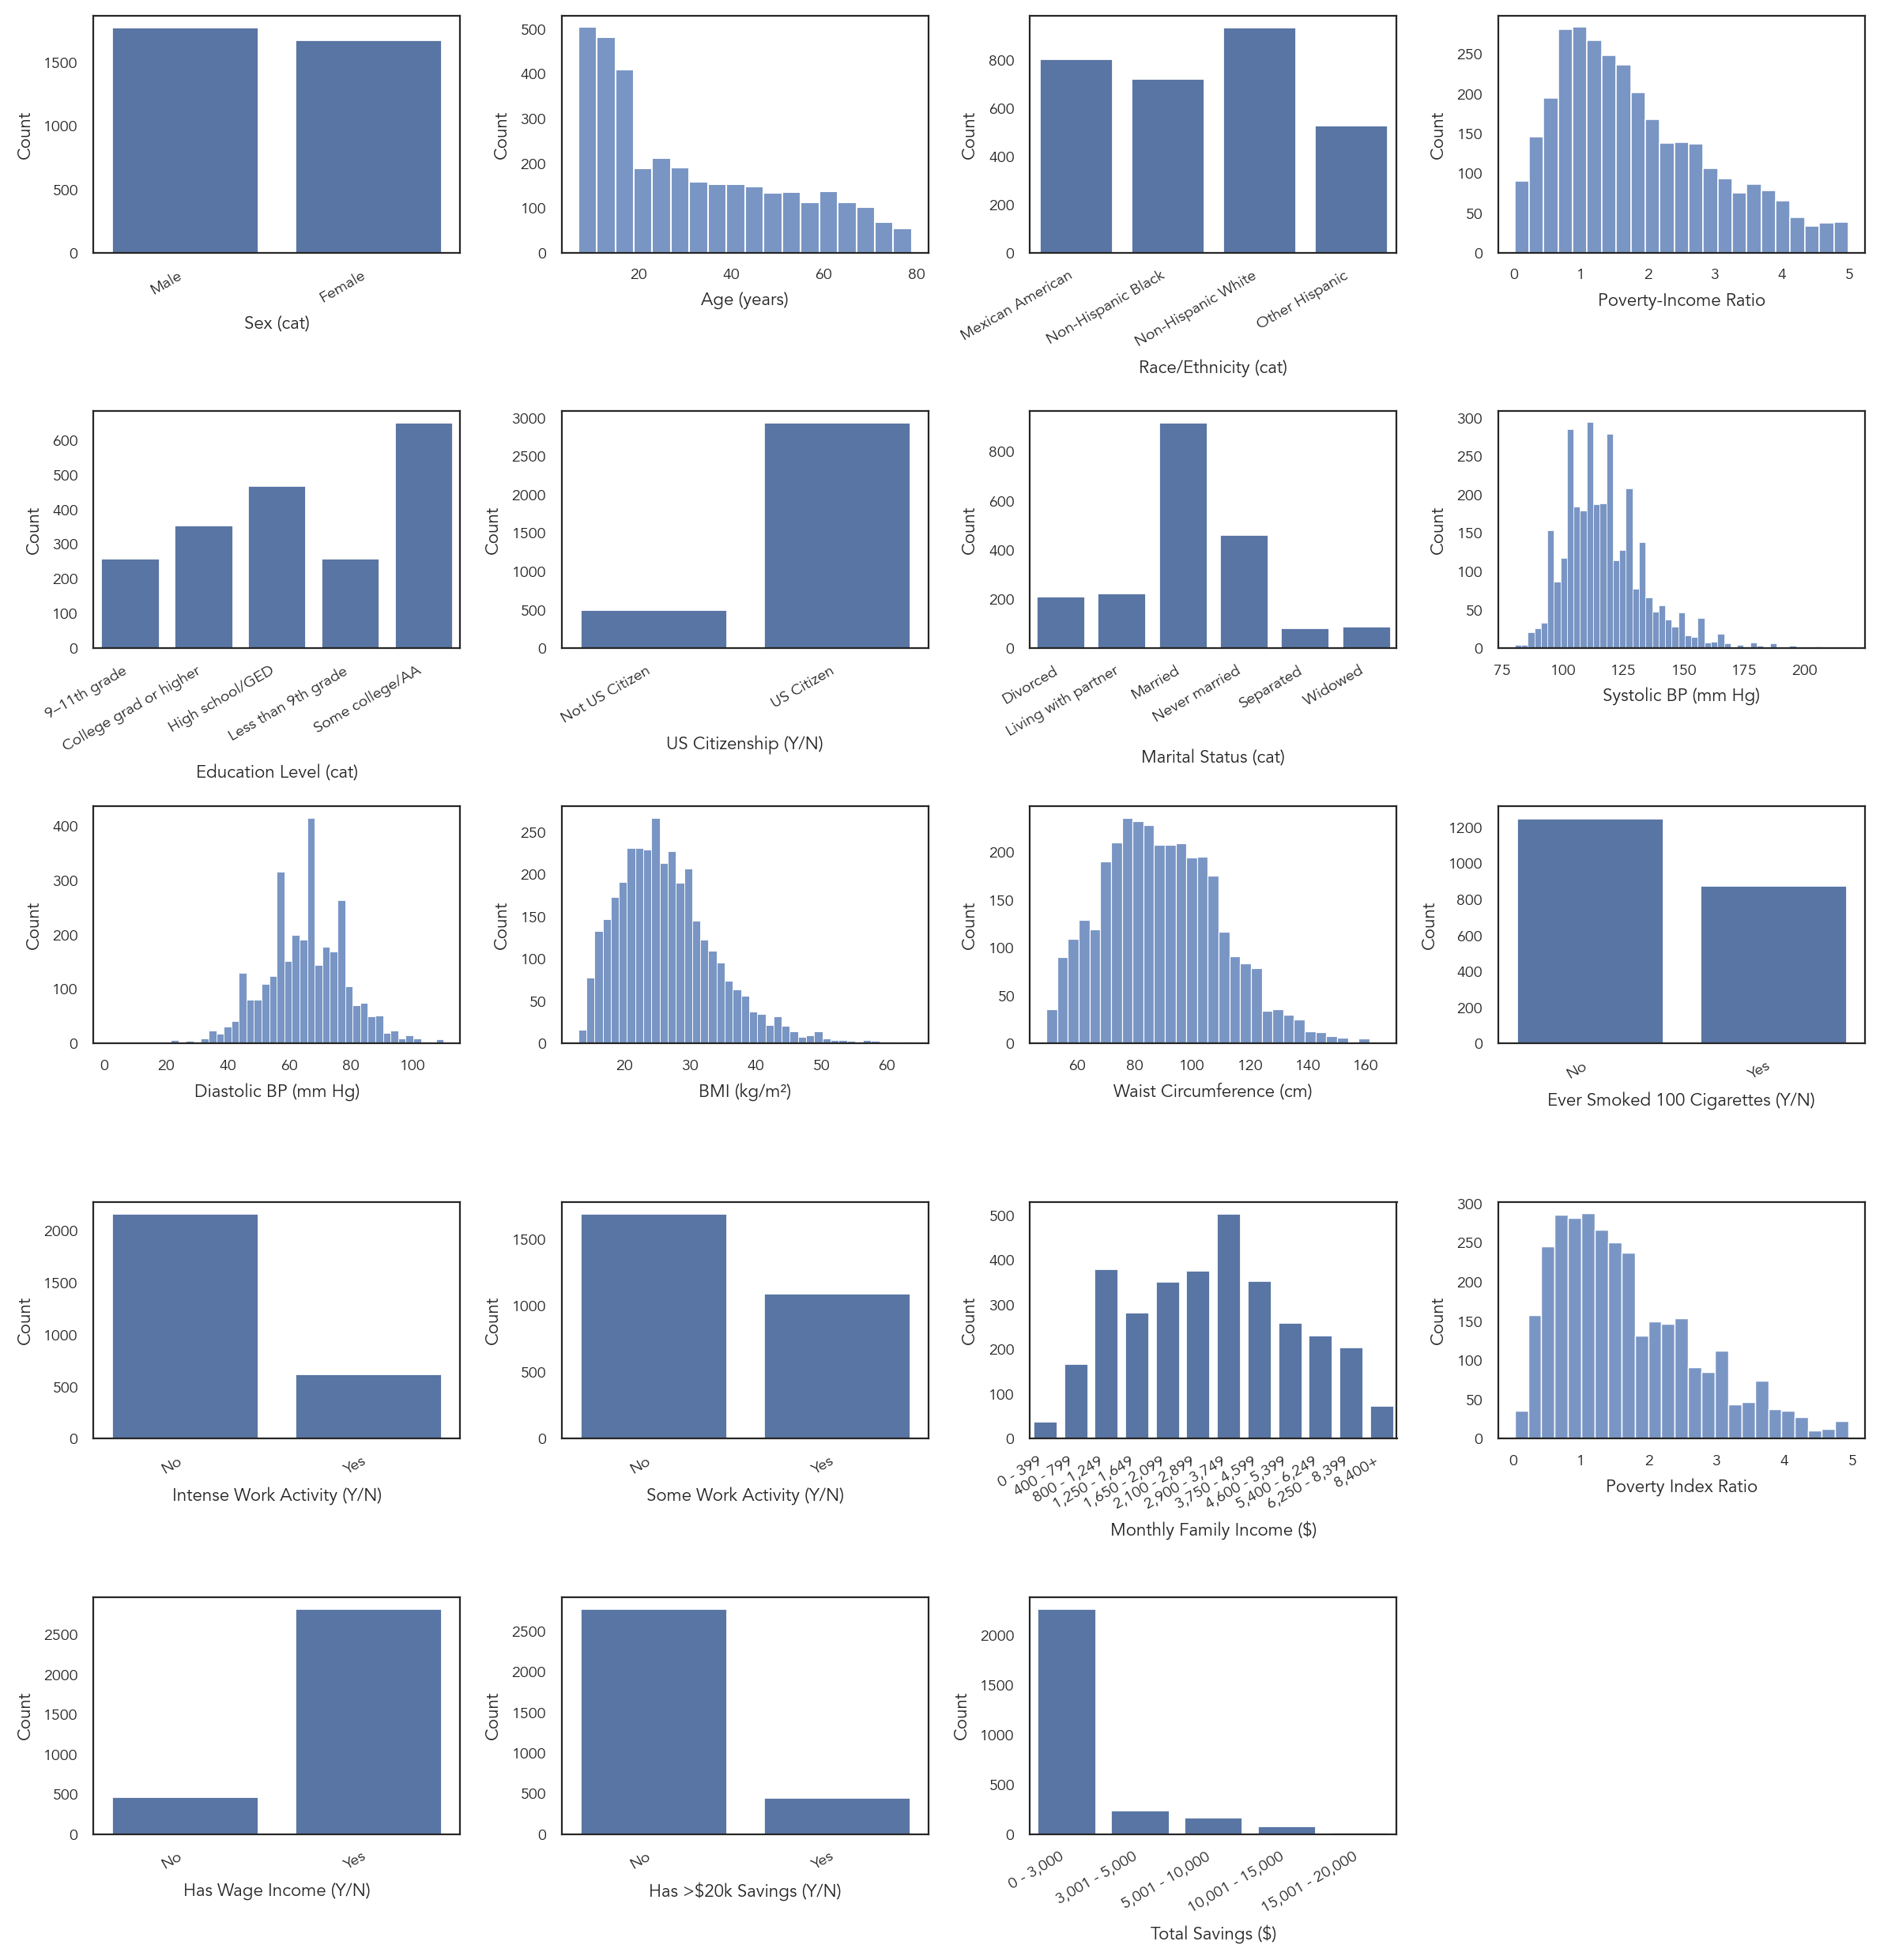

In [13]:
# Plot distributions of numeric featurees

# === Features to plot (excluding ID + targets) ===
features = [col for col in df_model.columns if col not in ['SEQN', 'vitamin_d', 'hdl_cholesterol']]

# === Subplot layout ===
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))
axes = axes.flatten()

# === Plot distributions ===
for i, col in enumerate(features):
    ax = axes[i]
    label = display_name_map.get(col, col)
    series = df_model[col]
    is_cat = is_categorical_dtype(series)

    if is_cat:
        sns.countplot(x=col, data=df_model, ax=ax, color='#4C72B0')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    else:
        sns.histplot(series, bins='fd', kde=False, ax=ax, color='#4C72B0')
        ax.tick_params(axis='x')

    ax.set_xlabel(label, fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(False)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

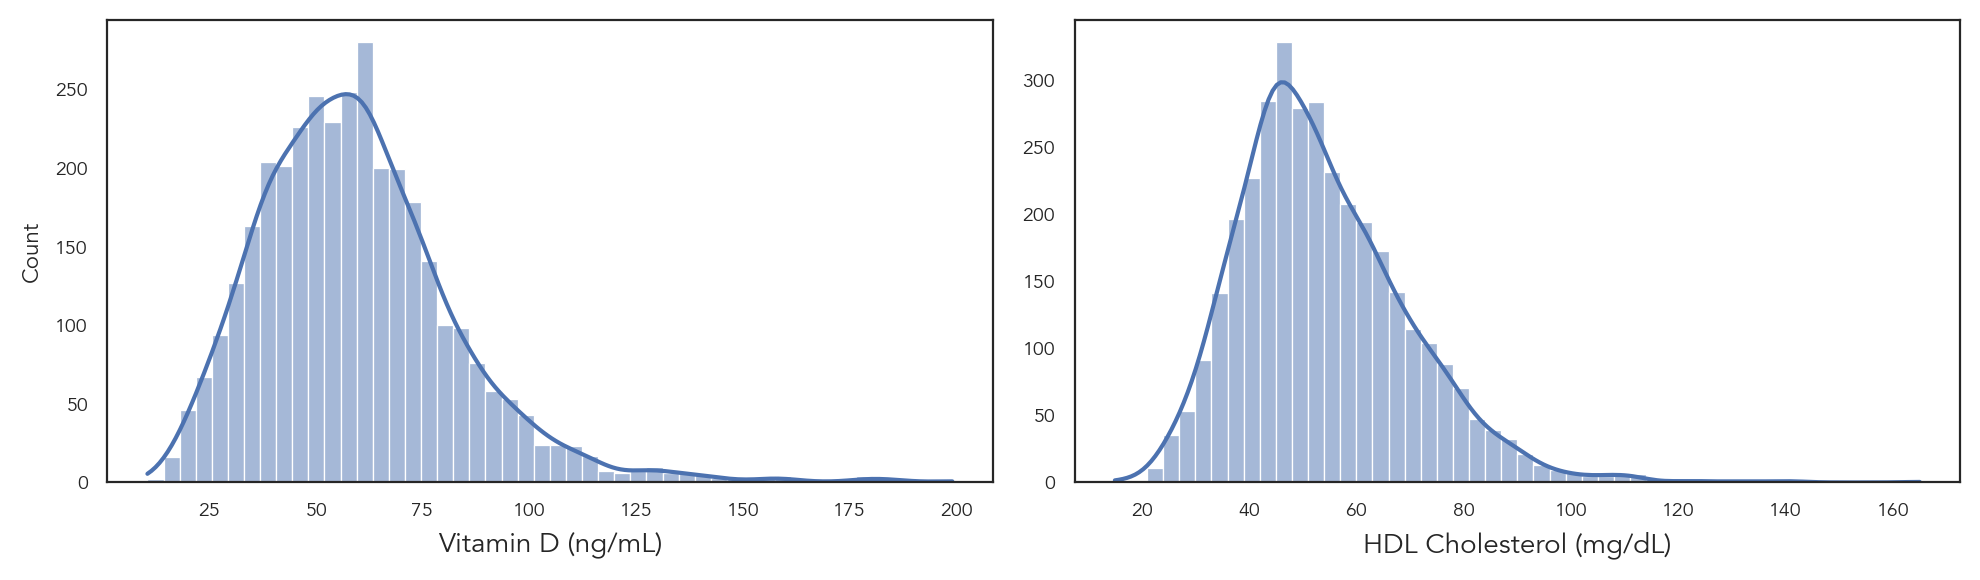

In [14]:
# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=False)

for i, col in enumerate(target_vars):
    label = display_name_map.get(col, col)
    sns.histplot(df_model[col], bins=50, kde=True, ax=axes[i], color='#4C72B0')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Count" if i == 0 else "", fontsize=8)
    axes[i].tick_params(axis='both', labelsize=7)
    axes[i].grid(False)

plt.tight_layout()
plt.show()


In [15]:
# Compute summary stats only for current numerical features
summary = df_model[num_features].describe().T
summary = summary.round(2)

# Rename index using display names
summary.index = [display_name_map.get(col, col) for col in summary.index]

# Display
summary

,count,mean,std,min,25%,50%,75%,max
Age (years),3454.0,30.83,20.02,7.00,14.00,25.00,46.00,79.00
Poverty-Income Ratio,3192.0,1.85,1.16,0.01,0.94,1.59,2.60,4.99
Systolic BP (mm Hg),3129.0,117.43,17.03,80.00,106.00,114.00,126.00,218.00
Diastolic BP (mm Hg),3129.0,65.19,13.30,2.00,56.00,66.00,74.00,110.00
BMI (kg/m²),3427.0,26.55,7.66,12.90,21.10,25.50,30.70,63.90
Waist Circumference (cm),3311.0,89.64,20.33,49.50,74.65,88.20,103.10,165.00
Poverty Index Ratio,3234.0,1.67,1.04,0.02,0.84,1.47,2.32,4.95


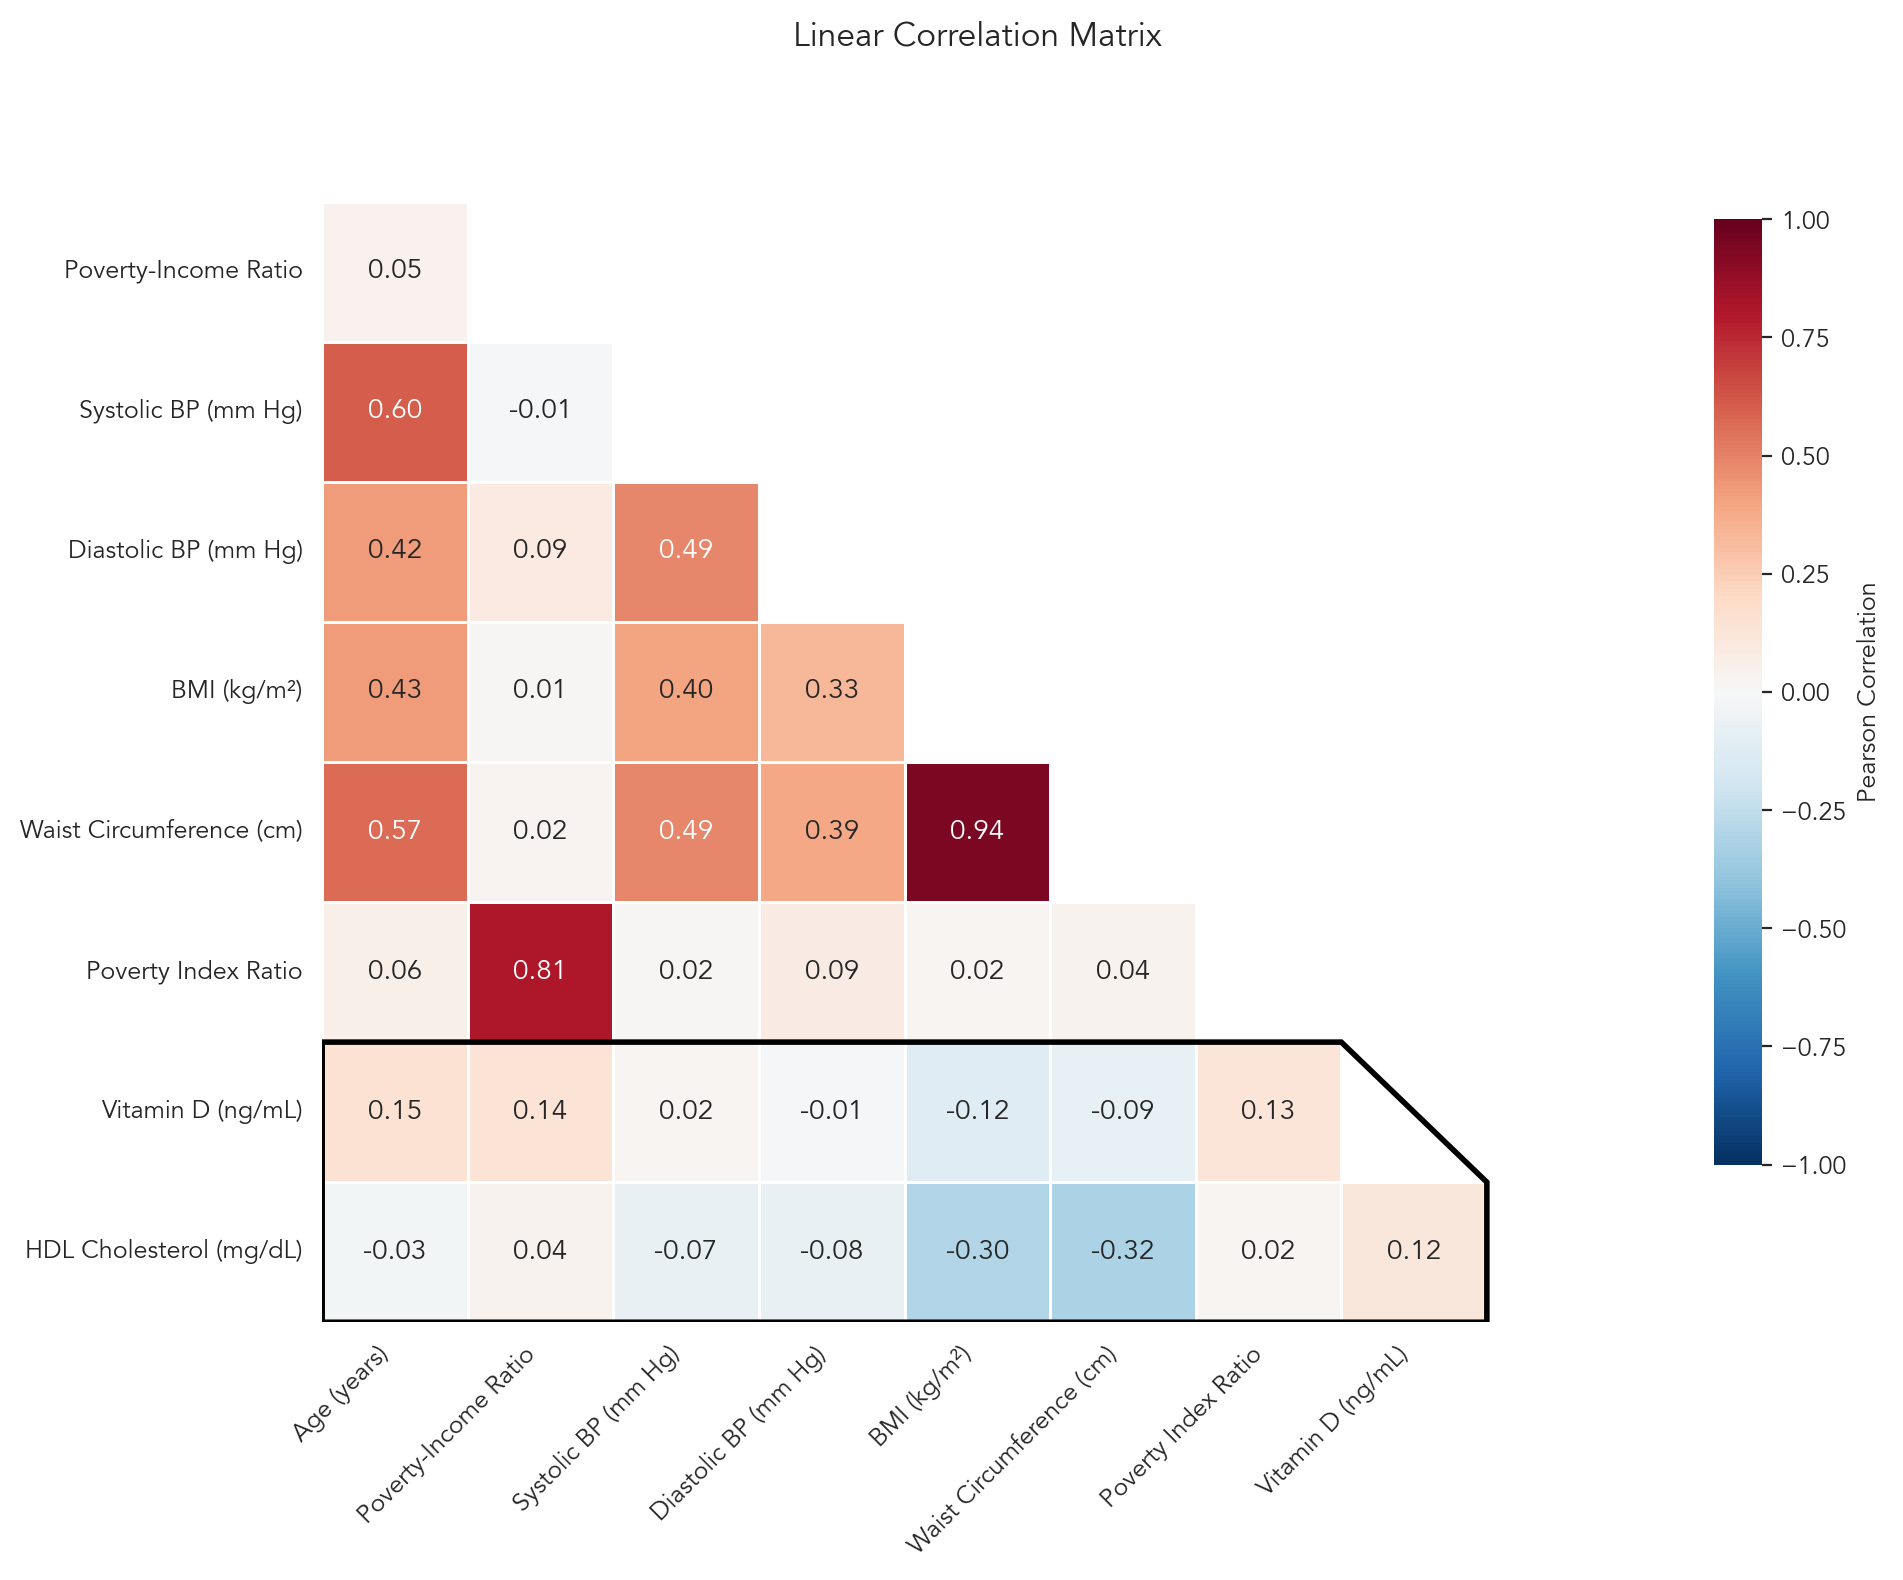

In [22]:
# === Compute correlation matrix
corr = df_model.drop(columns='SEQN').corr(numeric_only=True)

# === Rename with display names
renamed = [display_name_map.get(col, col) for col in corr.columns]
corr.index = renamed
corr.columns = renamed

# === Define target variable display names
target_labels = [display_name_map[t] for t in ['vitamin_d', 'hdl_cholesterol']]
target_rows = [corr.index.get_loc(t) for t in target_labels]

# === Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# === Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

# === Label the colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Pearson Correlation', fontsize=9)

# === Optional polygon highlight
min_row = min(target_rows)
max_row = max(target_rows)
polygon_points = [
    [0, min_row],
    [min_row, min_row],
    [max_row, max_row],
    [max_row, max_row + 1],
    [0, max_row + 1]
]
polygon = patches.Polygon(polygon_points, closed=True, fill=False, edgecolor='black', linewidth=2)
ax.add_patch(polygon)

# === Whiten labels (custom logic)
for tick in ax.get_xticklabels():
    if tick.get_text() == display_name_map['hdl_cholesterol']:
        tick.set_color('white')
for tick in ax.get_yticklabels():
    if tick.get_text() == display_name_map['age']:
        tick.set_color('white')

# === Final formatting
plt.title("Linear Correlation Matrix", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [24]:
# === Define consistent color palette keyed by raw column names ===
target_colors = {
    'vitamin_d': '#1f77b4',        # blue
    'hdl_cholesterol': '#ff7f0e',  # orange
}

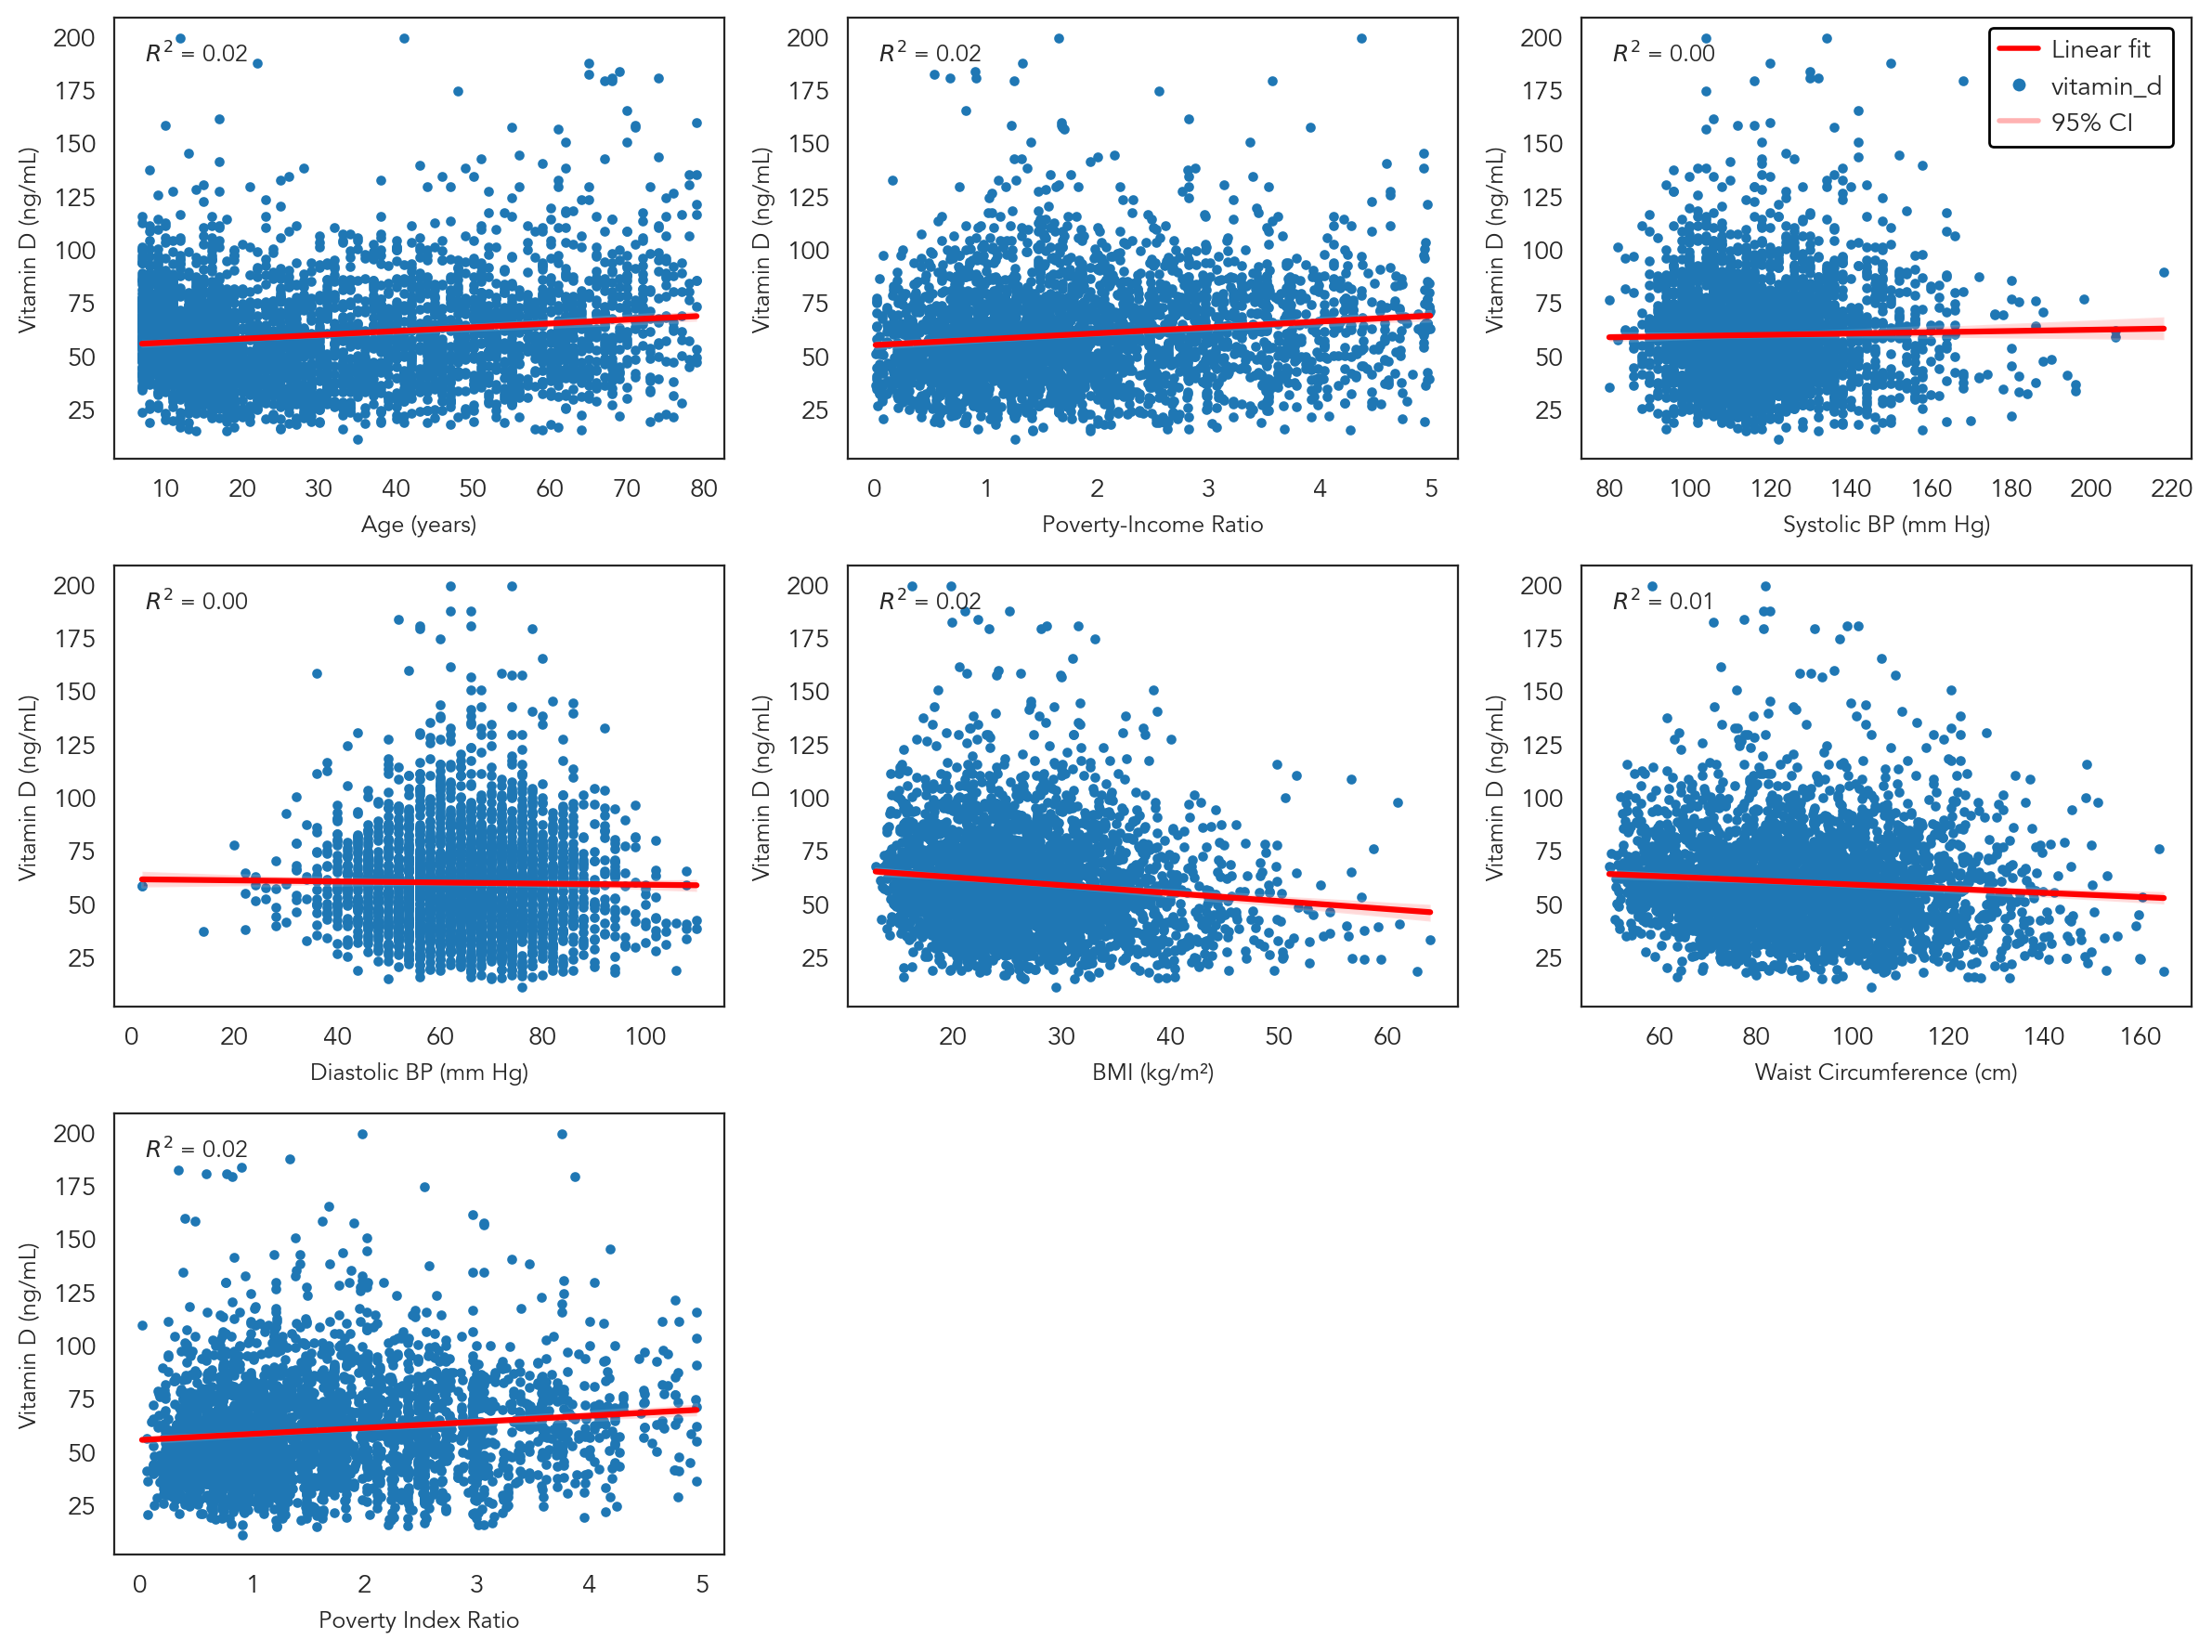

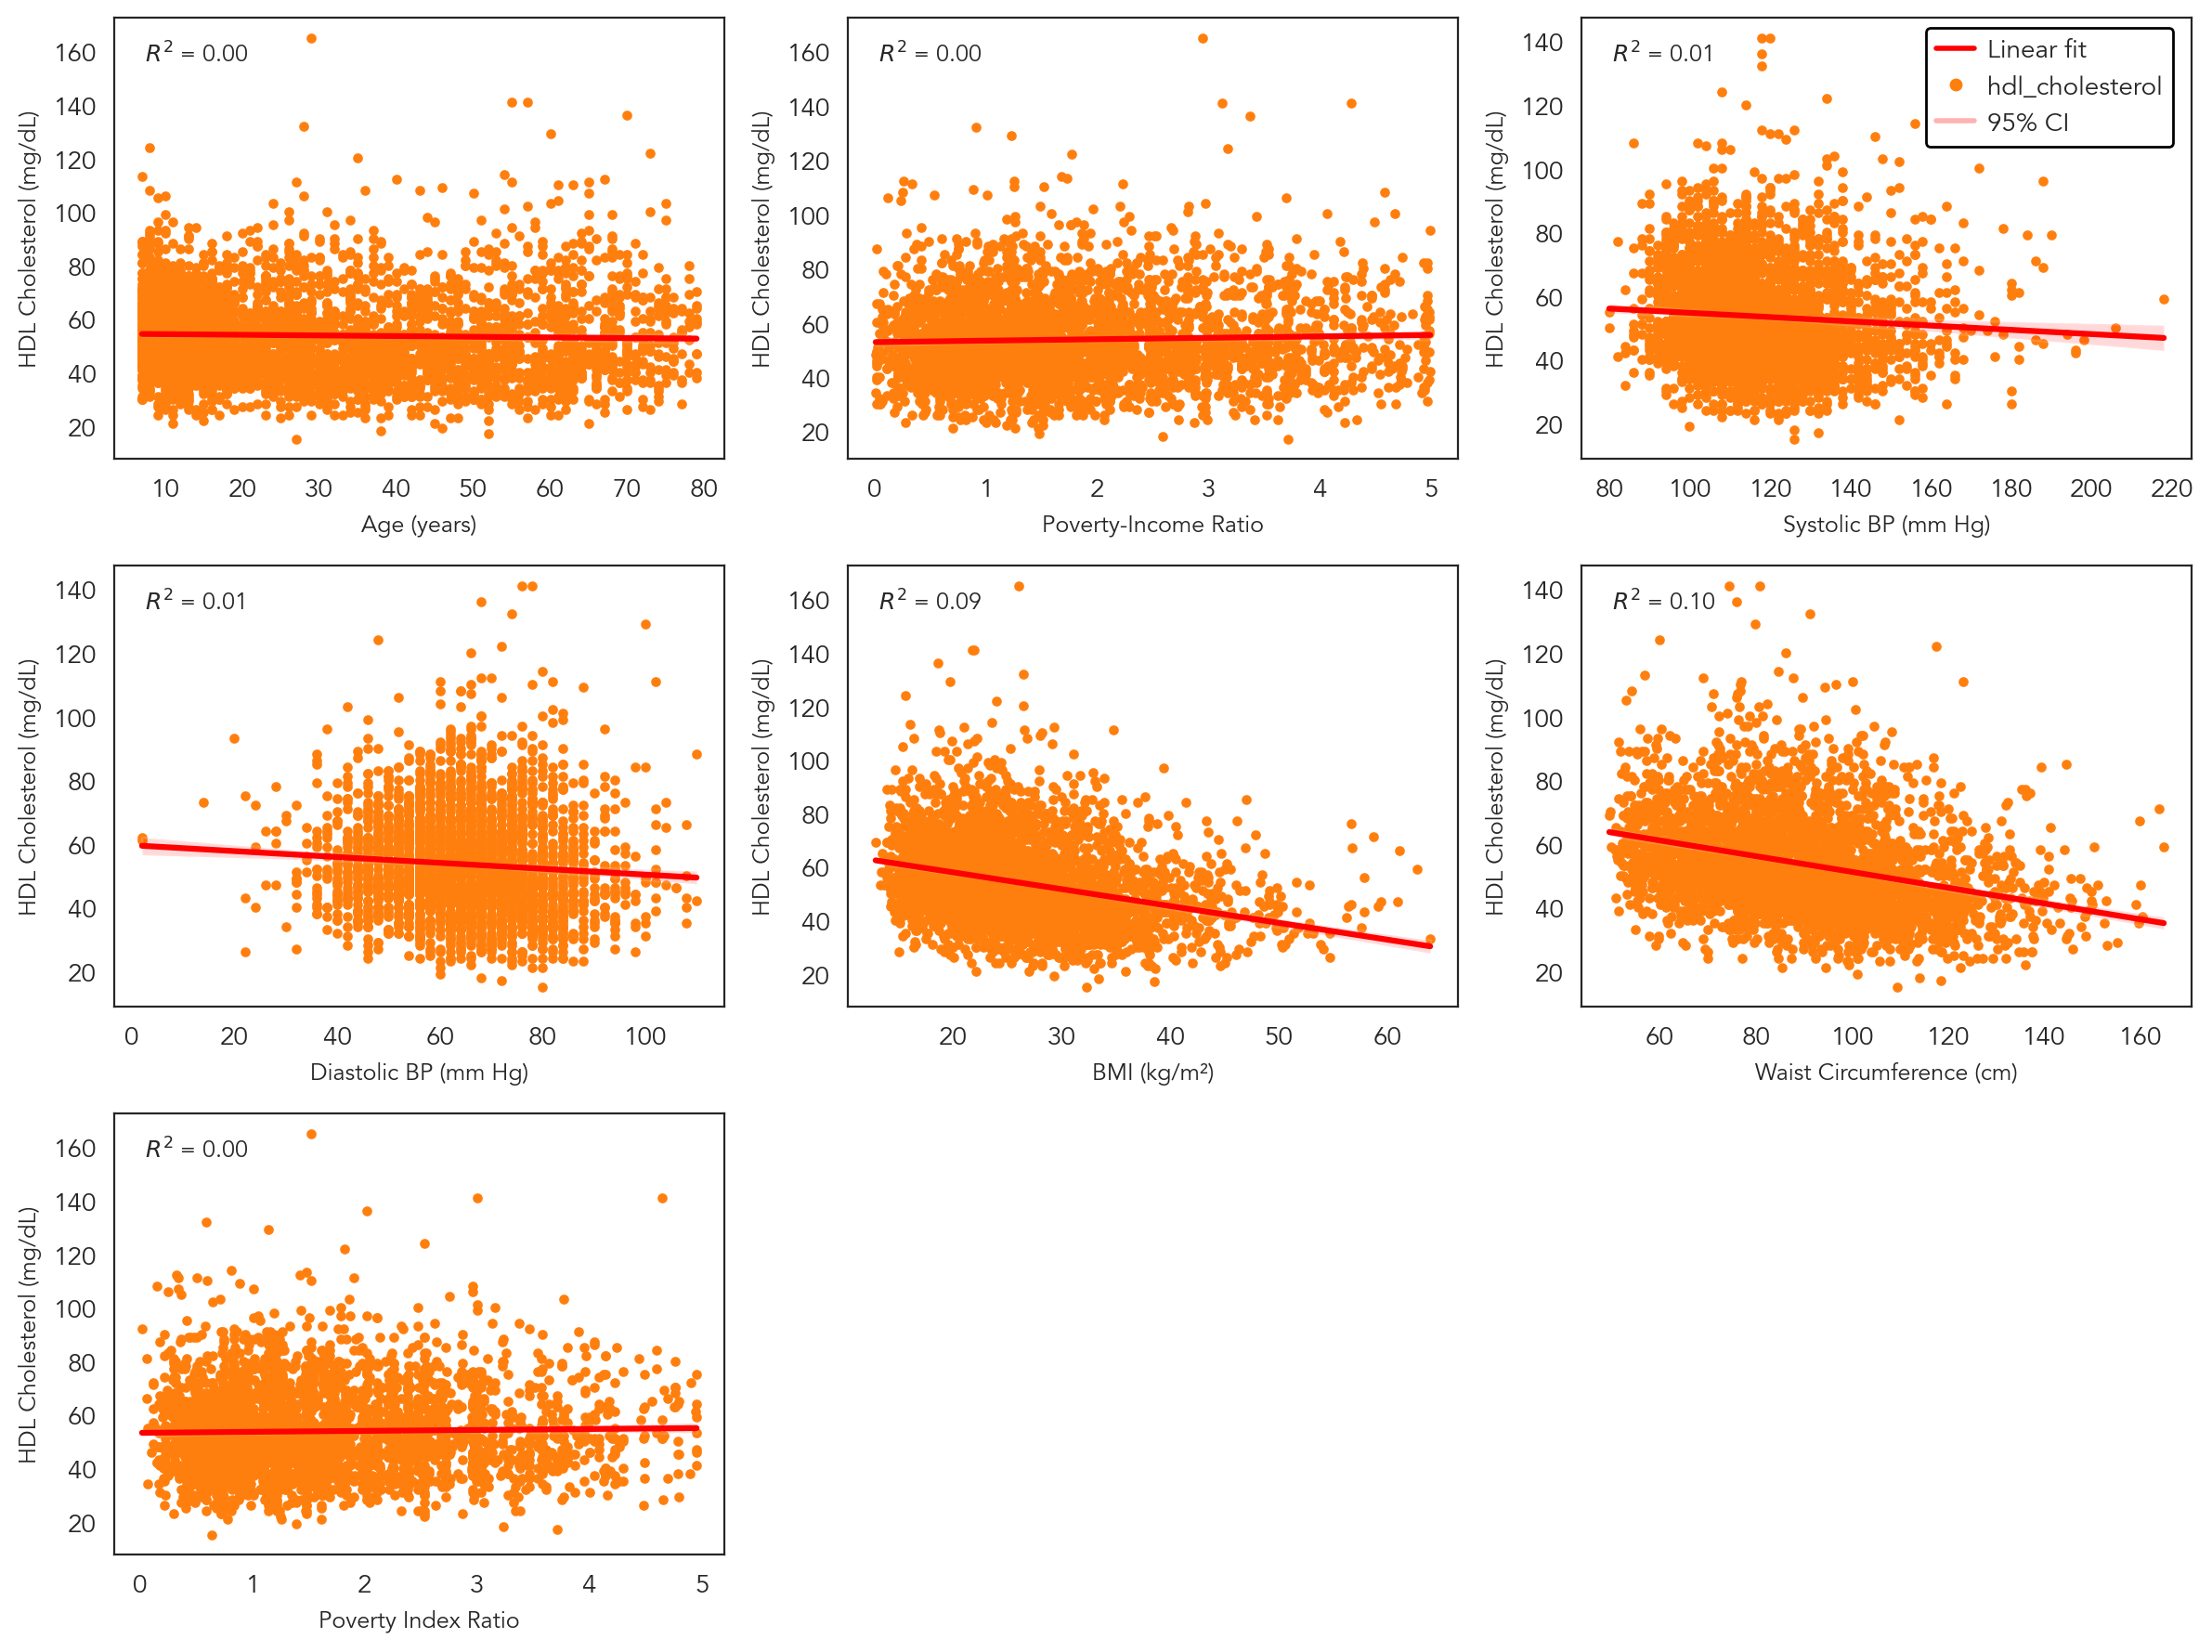

,Vitamin D (ng/mL),HDL Cholesterol (mg/dL)
Age (years),0.024,0.001
Poverty-Income Ratio,0.019,0.001
Systolic BP (mm Hg),0.000,0.005
Diastolic BP (mm Hg),0.000,0.006
BMI (kg/m²),0.015,0.092
Waist Circumference (cm),0.007,0.101
Poverty Index Ratio,0.016,0.001


In [26]:
numeric_features = [f for f in num_features if f not in target_vars]

# === Initialize R² table
r2_table = pd.DataFrame(index=numeric_features, columns=target_vars, dtype=float)

# === Plot settings
sns.set_style("white")
n_cols = 3
n_rows = int(np.ceil(len(numeric_features) / n_cols))

for target in target_vars:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        subset = df_model[[feature, target]].dropna()
        X = subset[[feature]].values
        y = subset[target].values

        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        r2_table.loc[feature, target] = r2

        sns.regplot(
            x=feature,
            y=target,
            data=df_model,
            ax=ax,
            ci=95,
            scatter_kws={'alpha': 1, 's': 8, 'color': target_colors[target]},            
            line_kws={'color': 'red'}
        )

        ax.set_xlabel(display_name_map.get(feature, feature), fontproperties=avenir_font, fontsize=9)
        ax.set_ylabel(display_name_map.get(target, target), fontproperties=avenir_font, fontsize=9)
        ax.grid(False)
        ax.annotate(f"$R^2$ = {r2:.2f}", xy=(0.05, 0.90), xycoords="axes fraction", 
                    fontproperties=avenir_font, fontsize=9)

        # Optional: also set tick label font
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(avenir_font)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Shared legend with Avenir
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Linear fit'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=target_colors[target], markersize=6, label=target),
        Line2D([0], [0], color='red', lw=2, alpha=0.3, label='95% CI')
    ]
    fig.legend(
        handles=legend_elements,
        loc='upper right',
        bbox_to_anchor=(0.985, 0.985),
        frameon=True,
        facecolor='white',
        edgecolor='black',
        framealpha=1,
        fontsize=8,
        handlelength=1.5,
        handletextpad=0.5,
        borderpad=0.4,
        labelspacing=0.4,
        prop=avenir_font  
    )

    plt.tight_layout()
    plt.show()

# === R² summary table with display names
r2_table_display = r2_table.round(3)
r2_table_display.index = [display_name_map.get(f, f) for f in r2_table_display.index]
r2_table_display.columns = [display_name_map.get(t, t) for t in r2_table_display.columns]
r2_table_display

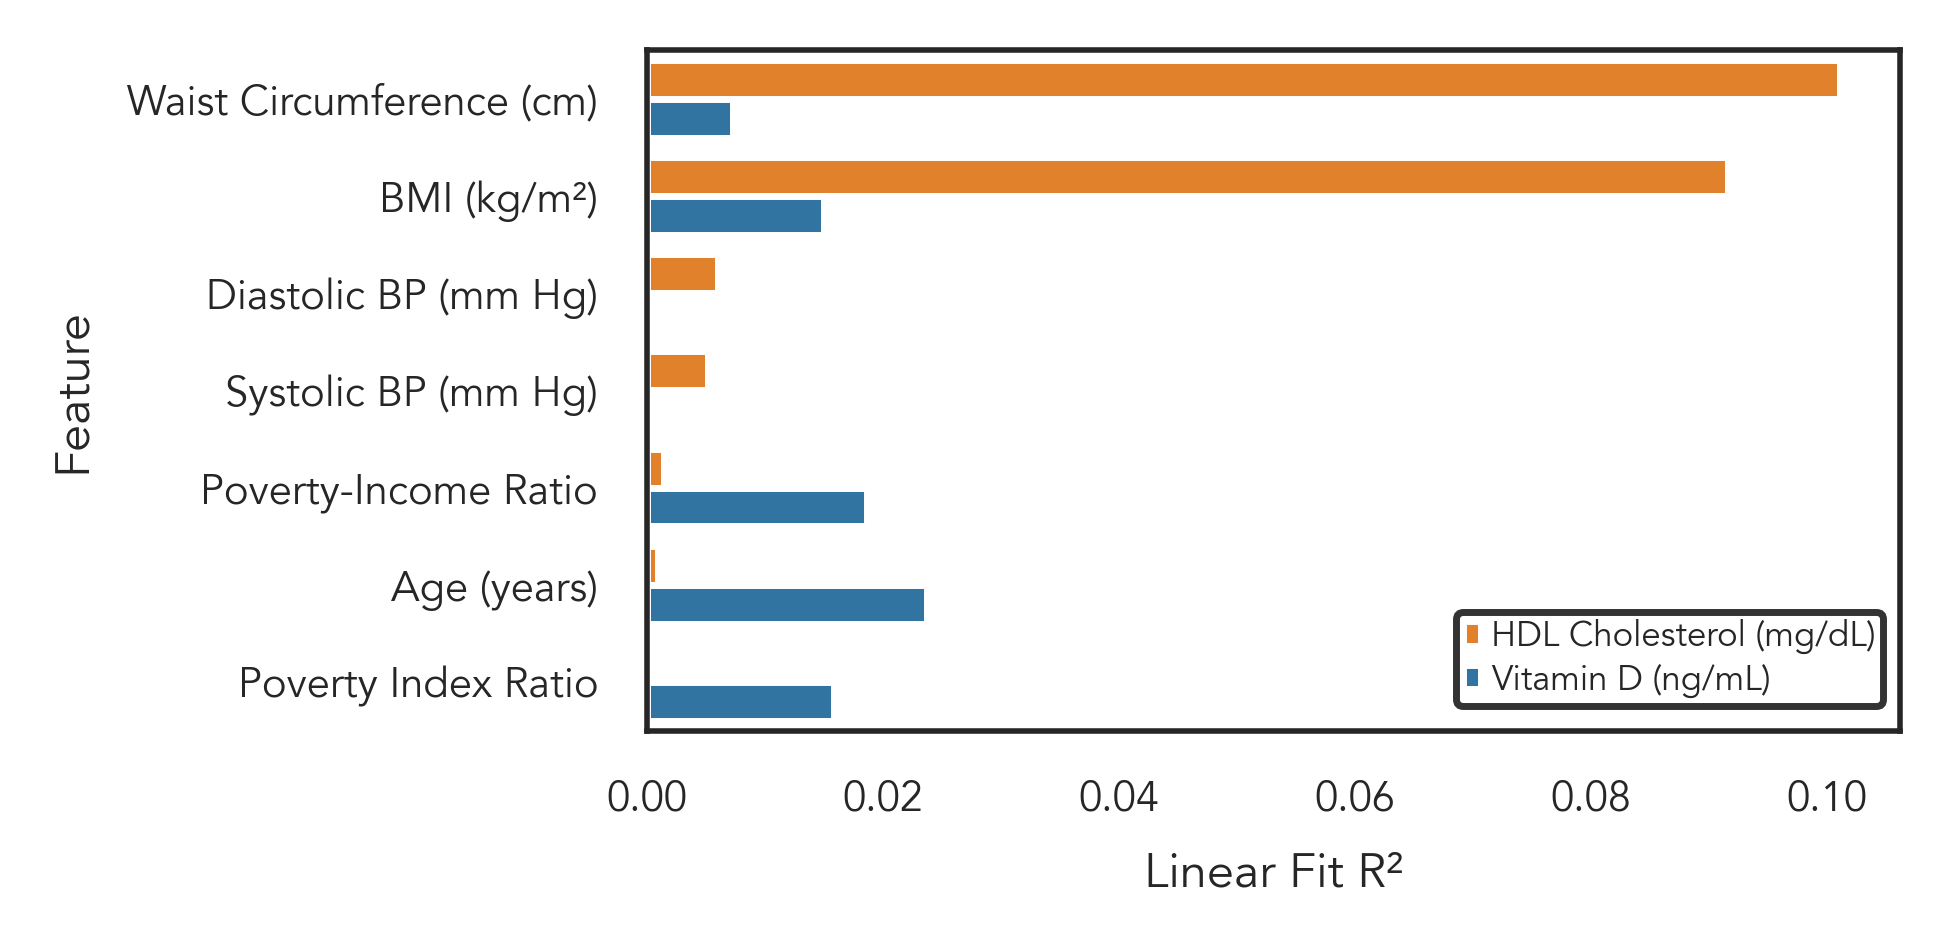

In [28]:
palette = {display_name_map[t]: target_colors[t] for t in target_vars}

# === Long-form melt for barplot
r2_long = (
    r2_table.reset_index()
    .melt(id_vars='index', var_name='Target', value_name='R²')
    .rename(columns={'index': 'Feature'})
)

# Map display labels
r2_long['Display Feature'] = r2_long['Feature'].map(display_name_map)
r2_long['Display Target'] = r2_long['Target'].map(display_name_map)
r2_long = r2_long.sort_values(['Display Target', 'R²'], ascending=[True, False])



# Plot
plt.figure(figsize=(4, 2), dpi=500)
ax = sns.barplot(
    data=r2_long,
    x='R²',
    y='Display Feature',
    hue='Display Target',
    palette=palette
)

# Axis labels
ax.set_xlabel('Linear Fit R²', fontproperties=avenir_font, fontsize=7)
ax.set_ylabel('Feature', fontproperties=avenir_font, fontsize=7)

# Tick labels
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(avenir_font)
    tick.set_fontsize(6)

avenir_font_small = FontProperties(family='Avenir', size=5) 

# Compact legend
plt.legend(
    title=None,
    fontsize=2,
    title_fontsize=4,
    loc='lower right',
    bbox_to_anchor=(1, 0.01),  # pull it tighter to the corner
    frameon=True,
    facecolor='white',
    edgecolor='black',
    handlelength=0.5,      # shorter bars
    handletextpad=0.3,     # space between bar and label
    borderpad=0.2,         # padding inside the box
    labelspacing=0.2,      # spacing between legend entries
    columnspacing=0.3,
    prop=avenir_font_small
)

plt.tight_layout()
plt.show()


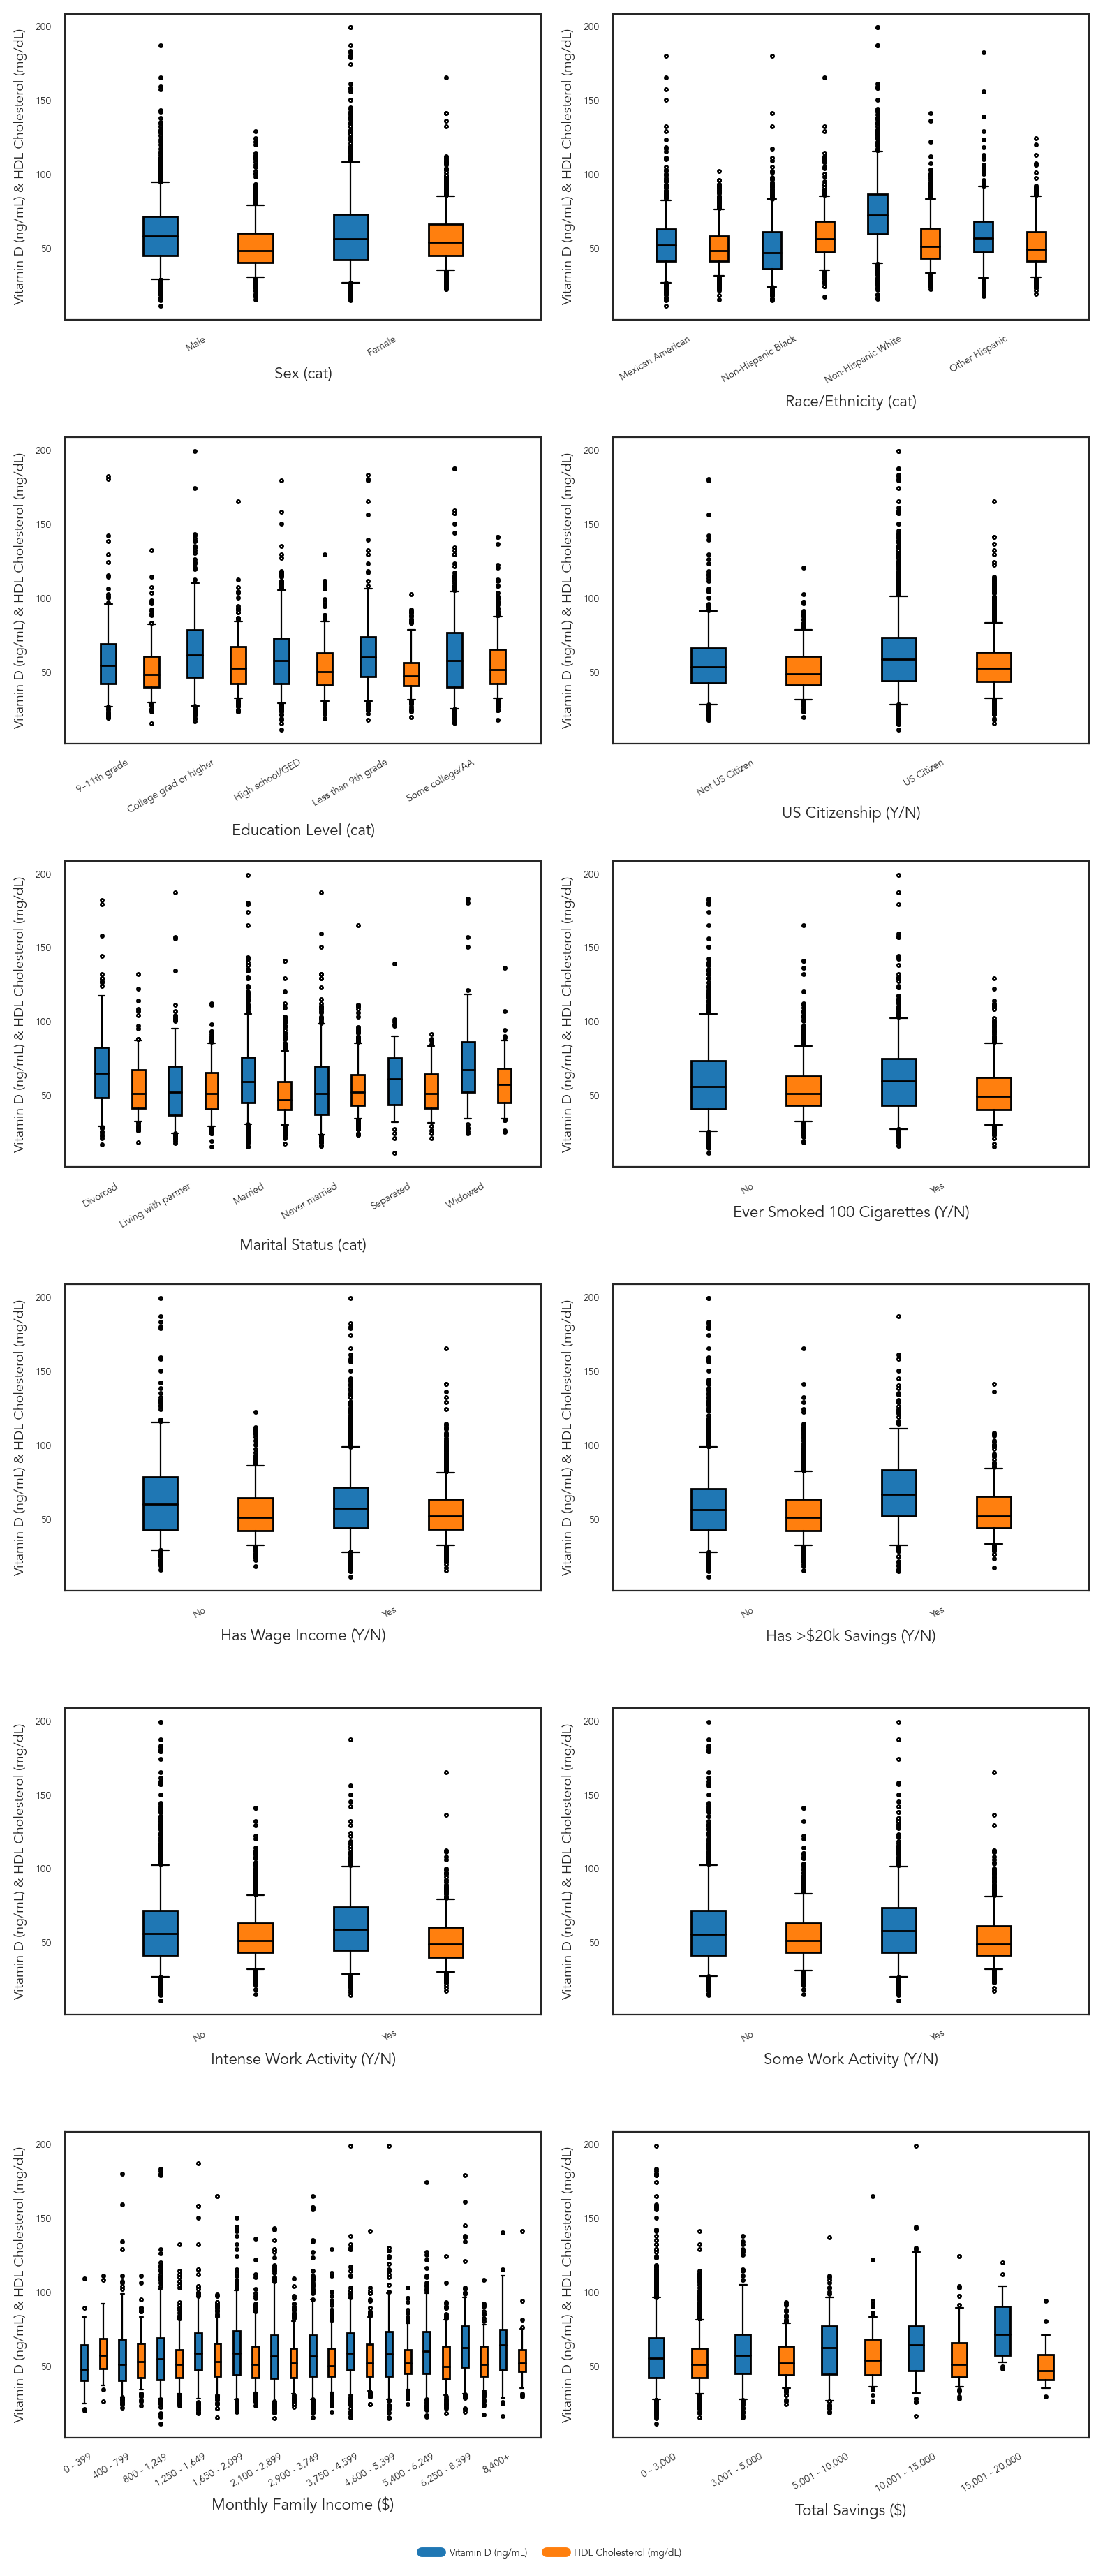

In [30]:
# === Boxplot Grid for Categorical Features ===

plot_cat_features = cat_features.copy()
n_cols = 2
n_rows = int(np.ceil(len(plot_cat_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.2 * n_rows))
axes = axes.flatten()

base_box_param = dict(
    whis=(5, 95), widths=0.18, patch_artist=True,
    flierprops=dict(marker='.', markeredgecolor='black', markersize=3, linestyle='none'),
    medianprops=dict(color='black', linewidth=1),
    whiskerprops=dict(linewidth=0.8),
    capprops=dict(linewidth=0.8)
)

space = 0.25
offsets = [-space, space]  # Just two offsets for two targets

for i, cat in enumerate(plot_cat_features):
    ax = axes[i]

    categories = df_model[cat].cat.categories.tolist()
    nb_groups = len(categories)
    if nb_groups < 2:
        ax.axis('off')
        continue

    # Gather per-category data for each target
    target_data = {
        t: [df_model.loc[(df_model[cat] == c) & df_model[t].notna(), t] for c in categories]
        for t in target_vars
    }

    # Plot left y-axis targets (HDL + Triglycerides)
    for idx, t in enumerate(target_vars):
        data = target_data[t]
        valid_data = [d for d in data if len(d) > 0]
        valid_pos = [p for d, p in zip(data, np.arange(nb_groups) + offsets[idx]) if len(d) > 0]
        if valid_data:
            ax.boxplot(valid_data, positions=valid_pos,
                       boxprops=dict(facecolor=target_colors[t]), **base_box_param)

    # X and Y labels
    ax.set_xticks(np.arange(nb_groups))
    ax.set_xticklabels(categories, rotation=30, ha='right')
    ax.set_xlabel(display_name_map.get(cat, cat), fontproperties=avenir_font, fontsize=8)
    ax.set_ylabel(
        f"{display_name_map[target_vars[0]]} & {display_name_map[target_vars[1]]}",
        fontproperties=avenir_font, fontsize=7
    )

    # Tick font
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontproperties(avenir_font_small)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Shared legend
handles = [
    plt.Line2D([0], [0], color=target_colors[t], lw=5, label=display_name_map[t])
    for t in target_vars
]
fig.legend(
    handles=handles,
    title=None,
    fontsize=6,
    title_fontsize=7,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.04),
    ncol=2,
    frameon=False,
    prop=avenir_font_small
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [32]:
# Output directory
output_path = Path("../data/processed")
output_path.mkdir(parents=True, exist_ok=True)

# Save data
df_model.reset_index(drop=True).to_feather(output_path / "cleaned_nhanes.feather")
df_model.to_csv(output_path / "cleaned_nhanes.csv", index=False)

# Save metadata
meta = {
    "target_cols": target_cols,
    "cat_features": cat_features,
    "num_features": num_features
}
with open(output_path / "metadata.json", "w") as f:
    json.dump(meta, f)

print("✅ Saved cleaned dataset to:")
print(f"  • {output_path / 'cleaned_nhanes.feather'}")
print(f"  • {output_path / 'cleaned_nhanes.csv'}")


✅ Saved cleaned dataset to:
  • ../data/processed/cleaned_nhanes.feather
  • ../data/processed/cleaned_nhanes.csv
